In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import warnings
from custom import custom_funcs as cf
from itertools import combinations

warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Load Data

As usual, let's start by loading some network data. This time round, we have a [physician trust](http://konect.uni-koblenz.de/networks/moreno_innovation) network, but slightly modified such that it is undirected rather than directed.

> This directed network captures innovation spread among 246 physicians in for towns in Illinois, Peoria, Bloomington, Quincy and Galesburg. The data was collected in 1966. A node represents a physician and an edge between two physicians shows that the left physician told that the righ physician is his friend or that he turns to the right physician if he needs advice or is interested in a discussion. There always only exists one edge between two nodes even if more than one of the listed conditions are true.

In [2]:
# Load the network. This network, while in reality is a directed graph,
# is intentionally converted to an undirected one for simplification.
G = cf.load_physicians_network()

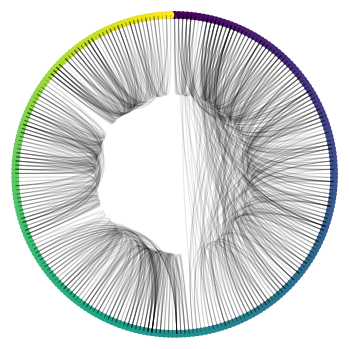

In [3]:
# Make a Circos plot of the graph
import numpy as np
from circos import CircosPlot

nodes = sorted(G.nodes())
edges = G.edges()
edgeprops = dict(alpha=0.1)
nodecolor = plt.cm.viridis(np.arange(len(nodes)) / len(nodes)) 
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
c = CircosPlot(nodes, edges, radius=10, ax=ax, edgeprops=edgeprops, nodecolor=nodecolor)
c.draw()

### Question

What can you infer about the structure of the graph from the Circos plot?

My answer: The structure is interesting. The graph looks like the physician trust network is comprised of discrete subnetworks.

## Structures in a Graph

We can leverage what we have learned in the previous notebook to identify special structures in a graph. 

In a network, cliques are one of these special structures.

## Cliques

In a social network, cliques are groups of people in which everybody knows everybody. 

**Questions:**
1. What is the simplest clique?
1. What is the simplest complex clique?

Let's try implementing a simple algorithm that finds out whether a node is present in a simple complex clique.

In [4]:
# Example code.
def in_triangle(G, node):
    """
    Returns whether a given node is present in a triangle relationship or not.
    """
    # We first assume that the node is not present in a triangle.
    is_in_triangle = False
    
    # Then, iterate over every pair of the node's neighbors.
    for nbr1, nbr2 in combinations(G.neighbors(node), 2):
        # Check to see if there is an edge between the node's neighbors.
        # If there is an edge, then the given node is present in a triangle.
        if G.has_edge(nbr1, nbr2):
            is_in_triangle = True
            # We break because any triangle that is present automatically 
            # satisfies the problem requirements.
            break
    return is_in_triangle

in_triangle(G, 3)

True

In reality, NetworkX already has a function that *counts* the number of triangles that any given node is involved in. This is probably more useful than knowing whether a node is present in a triangle or not, but the above code was simply for practice.

In [5]:
nx.triangles(G, 3)

3

### Exercise

Can you write a function that takes in one node and its associated graph as an input, and returns a list or set of itself + all other nodes that it is in a triangle relationship with? Do not return the triplets, but the `set`/`list` of nodes.

**Possible Implementation:** If my neighbor's neighbor's neighbor includes myself, then we are in a triangle relationship.

**Possible Implementation:** If I check every pair of my neighbors, any pair that are also connected in the graph are in a triangle relationship with me.

Hint: Python's [`itertools`](https://docs.python.org/3/library/itertools.html) module has a `combinations` function that may be useful.

Hint: NetworkX graphs have a `.has_edge(node1, node2)` function that checks whether an edge exists between two nodes.

Verify your answer by drawing out the subgraph composed of those nodes.

In [6]:
# Possible answer
def get_triangles(G, node):
    neighbors1 = set(G.neighbors(node))
    triangle_nodes = set()
    triangle_nodes.add(node)
    """
    Fill in the rest of the code below.
    """
    for nbr1, nbr2 in combinations(neighbors1, 2):
        if G.has_edge(nbr1, nbr2):
            triangle_nodes.add(nbr1)
            triangle_nodes.add(nbr2)
    return triangle_nodes

# Verify your answer with the following funciton call. Should return something of the form:
# {3, 9, 11, 41, 42, 67}
get_triangles(G, 3)

{3, 9, 11, 41, 42, 67}

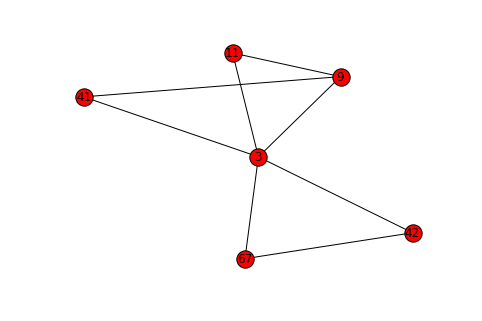

In [7]:
# Then, draw out those nodes.
nx.draw(G.subgraph(get_triangles(G, 3)), with_labels=True)

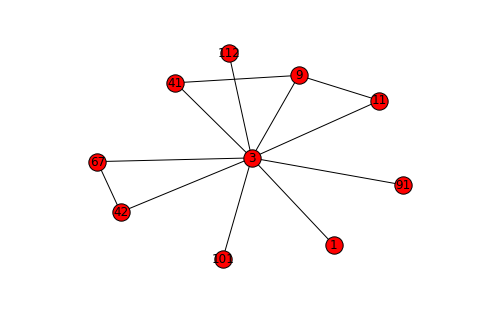

In [8]:
# Compare for yourself that those are the only triangles that node 3 is involved in.
neighbors3 = G.neighbors(3)
neighbors3.append(3)
nx.draw(G.subgraph(neighbors3), with_labels=True)

# Friend Recommendation: Open Triangles

Now that we have some code that identifies closed triangles, we might want to see if we can do some friend recommendations by looking for open triangles.

Open triangles are like those that we described earlier on - A knows B and B knows C, but C's relationship with A isn't captured in the graph. 

What are the two general scenarios for finding open triangles that a given node is involved in?

1. The given node is the centre node.
1. The given node is one of the termini nodes.

### Exercise
Can you write a function that identifies, for a given node, the other two nodes that it is involved with in an open triangle, if there is one?

Note: For this exercise, only consider the case when the node of interest is the centre node.

**Possible Implementation:** Check every pair of my neighbors, and if they are not connected to one another, then we are in an open triangle relationship.

In [9]:
# Possible Answer, credit Justin Zabilansky (MIT) for help on this.
def get_open_triangles(G, node):
    """
    There are many ways to represent this. One may choose to represent
    only the nodes involved in an open triangle; this is not the 
    approach taken here.
    
    Rather, we have a code that explicitly enumrates every open triangle present.
    """
    open_triangle_nodes = []
    neighbors = set(G.neighbors(node))
    
    for n1, n2 in combinations(neighbors, 2):
        if not G.has_edge(n1, n2):
            open_triangle_nodes.append([n1, node, n2])
    
    return open_triangle_nodes

In [10]:
# # Uncomment the following code if you want to draw out each of the triplets.
# nodes = get_open_triangles(G, 2)
# for i, triplet in enumerate(nodes):
#     fig = plt.figure(i)
#     nx.draw(G.subgraph(triplet), with_labels=True)
print(get_open_triangles(G, 3))
len(get_open_triangles(G, 3))

[[1, 3, 67], [1, 3, 101], [1, 3, 9], [1, 3, 41], [1, 3, 42], [1, 3, 11], [1, 3, 112], [1, 3, 91], [67, 3, 101], [67, 3, 9], [67, 3, 41], [67, 3, 11], [67, 3, 112], [67, 3, 91], [101, 3, 9], [101, 3, 41], [101, 3, 42], [101, 3, 11], [101, 3, 112], [101, 3, 91], [9, 3, 42], [9, 3, 112], [9, 3, 91], [41, 3, 42], [41, 3, 11], [41, 3, 112], [41, 3, 91], [42, 3, 11], [42, 3, 112], [42, 3, 91], [11, 3, 112], [11, 3, 91], [112, 3, 91]]


33

Triangle closure is also the core idea behind social networks' friend recommendation systems; of course, it's definitely more complicated than what we've implemented here.

## Cliques

We have figured out how to find triangles. Now, let's find out what **cliques** are present in the network. Recall: what is the definition of a clique?

- NetworkX has a [clique-finding](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.clique.find_cliques.html) algorithm implemented.
- This algorithm finds all maximally-sized cliques for a given node.
- Note that maximal cliques of size `n` include all cliques of `size < n`

In [11]:
list(nx.find_cliques(G))

[[1, 72],
 [1, 2],
 [1, 3],
 [1, 4, 5, 6],
 [1, 7],
 [2, 41],
 [2, 10],
 [2, 11, 40],
 [2, 11, 39],
 [2, 42, 110],
 [3, 67, 42],
 [3, 101],
 [3, 9, 41],
 [3, 9, 11],
 [3, 112],
 [3, 91],
 [4, 6, 32],
 [4, 6, 109],
 [4, 104],
 [4, 74, 116],
 [4, 46, 55],
 [4, 22],
 [4, 55, 32],
 [4, 59],
 [5, 38, 69],
 [5, 39],
 [5, 9, 8],
 [5, 9, 89],
 [5, 9, 66],
 [5, 9, 69],
 [5, 9, 85],
 [5, 45],
 [5, 91],
 [6, 31, 109],
 [7, 102],
 [8, 9, 10],
 [8, 9, 11],
 [8, 12, 11],
 [9, 70, 41],
 [9, 70, 10],
 [9, 40, 89, 11],
 [9, 40, 66],
 [9, 40, 69],
 [9, 40, 85],
 [9, 41, 69],
 [9, 10, 89],
 [9, 82, 85],
 [9, 53, 89],
 [10, 67, 89],
 [10, 102, 94],
 [10, 108],
 [10, 77, 89],
 [10, 77, 45],
 [10, 77, 38],
 [10, 83, 91],
 [10, 54],
 [10, 91, 94],
 [11, 65, 15],
 [11, 39, 12],
 [11, 40, 12, 15],
 [11, 40, 94],
 [11, 43, 15],
 [11, 79],
 [11, 87],
 [11, 28, 12],
 [11, 93],
 [12, 97, 19],
 [12, 97, 100],
 [12, 97, 47],
 [12, 67, 66],
 [12, 100, 28],
 [12, 40, 66],
 [12, 40, 75],
 [12, 40, 69, 73],
 [12, 108],


### Exercise

This should allow us to find all n-sized maximal cliques. Try writing a function `maximal_cliques_of_size(size, G)` that implements this.

In [12]:
def maximal_cliqes_of_size(size, G):
    # Defensive programming check.
    assert isinstance(size, int), "size has to be an integer"

    assert size >= 2, "cliques are of size 2 or greater."
    return [i for i in list(nx.find_cliques(G)) if len(i) == size]

maximal_cliqes_of_size(2, G)

[[1, 72],
 [1, 2],
 [1, 3],
 [1, 7],
 [2, 41],
 [2, 10],
 [3, 101],
 [3, 112],
 [3, 91],
 [4, 104],
 [4, 22],
 [4, 59],
 [5, 39],
 [5, 45],
 [5, 91],
 [7, 102],
 [10, 108],
 [10, 54],
 [11, 79],
 [11, 87],
 [11, 93],
 [12, 108],
 [13, 30],
 [14, 51],
 [14, 75],
 [15, 81],
 [15, 83],
 [15, 62],
 [16, 27],
 [17, 84],
 [18, 28],
 [20, 24],
 [21, 36],
 [21, 38],
 [24, 39],
 [24, 75],
 [24, 81],
 [24, 90],
 [25, 41],
 [25, 27],
 [26, 62],
 [27, 54],
 [28, 44],
 [28, 71],
 [29, 104],
 [29, 105],
 [29, 106],
 [29, 113],
 [29, 57],
 [30, 104],
 [30, 100],
 [31, 60],
 [32, 47],
 [35, 105],
 [35, 98],
 [36, 106],
 [38, 58],
 [39, 78],
 [41, 94],
 [41, 103],
 [42, 83],
 [42, 74],
 [44, 64],
 [44, 48],
 [45, 72],
 [45, 80],
 [45, 93],
 [46, 60],
 [48, 50],
 [48, 51],
 [49, 68],
 [49, 103],
 [50, 89],
 [51, 104],
 [51, 73],
 [51, 114],
 [52, 63],
 [53, 68],
 [53, 84],
 [53, 78],
 [54, 105],
 [55, 94],
 [55, 86],
 [56, 58],
 [57, 68],
 [58, 104],
 [58, 99],
 [58, 91],
 [58, 88],
 [59, 61],
 [60, 113

## Connected Components

From [Wikipedia](https://en.wikipedia.org/wiki/Connected_component_%28graph_theory%29):

> In graph theory, a connected component (or just component) of an undirected graph is a subgraph in which any two vertices are connected to each other by paths, and which is connected to no additional vertices in the supergraph.

NetworkX also implements a [function](https://networkx.github.io/documentation/networkx-1.9.1/reference/generated/networkx.algorithms.components.connected.connected_component_subgraphs.html) that identifies connected component subgraphs.

Remember how based on the Circos plot above, we had this hypothesis that the physician trust network may be divided into subgraphs. Let's check that, and see if we can redraw the Circos visualization.

In [13]:
ccsubgraphs = list(nx.connected_component_subgraphs(G))
ccsubgraphs

### Exercise

Play a bit with the Circos API. Can you colour the nodes by their subgraph identifier?

In [14]:
# Start by labelling each node in the master graph G by some number
# that represents the subgraph that contains the node.
for i, g in enumerate(ccsubgraphs):
    for n in g.nodes():
        G.node[n]['subgraph'] = i
        
# Then, pass in a list of nodecolors that correspond to the node order.
# Feel free to change the colours around!
node_cmap = {0: 'red', 1:'blue', 2: 'green', 3:'yellow'}
nodecolor = [node_cmap[G.node[n]['subgraph']] for n in sorted(G.nodes())]

nodes = sorted(G.nodes())
edges = G.edges()
edgeprops = dict(alpha=0.1)

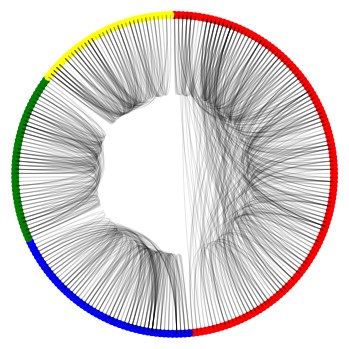

In [15]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
c = CircosPlot(nodes, edges, radius=10, ax=ax, fig=fig, edgeprops=edgeprops, nodecolor=nodecolor)
c.draw()
plt.savefig('images/physicians.png', dpi=300)

And "admire" the division of the US congress over the years...

![Congress Voting Patterns](https://img.washingtonpost.com/wp-apps/imrs.php?src=https://img.washingtonpost.com/blogs/wonkblog/files/2015/04/journal.pone_.0123507.g002.png&w=1484)